In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import datetime
import seaborn as sns
import missingno as msno
import firebase_admin
from firebase_admin import credentials, db
from datetime import datetime  # Untuk konversi timestamp ke human-readable
sns.set_theme(style="whitegrid")
%matplotlib inline 

In [2]:
# Konfigurasi database sumber
source_cred = credentials.Certificate("D:/staklimjerukagung-firebase-adminsdk-kcfma-e091165a9b.json")
firebase_admin.initialize_app(source_cred, {
    'databaseURL': 'https://staklimjerukagung-default-rtdb.asia-southeast1.firebasedatabase.app/'
})

In [160]:
# Input readable date
start_readable_date = "01-11-2025 00:00:00"  # Format: DD-MM-YYYY HH:MM:SS
end_readable_date = "30-11-2025 23:59:59"  # Format: DD-MM-YYYY HH:MM:SS

# Convert readable date to Unix timestamp
start_timestamp = int(datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(start_timestamp) # Convert to string and print
end_timestamp = int(datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S").timestamp())
print(end_timestamp) # Convert to string and print


1761930000
1764521999


In [161]:
def fetch_weather_data(station_id, start_ts, end_ts):
    """
    Mengambil data cuaca dari Firebase Realtime Database untuk stasiun dan rentang waktu tertentu.

    Args:
        station_id (str): ID stasiun cuaca (contoh: 'id-03', 'id-04').
        start_ts (int): Timestamp awal (epoch time).
        end_ts (int): Timestamp akhir (epoch time).

    Returns:
        dict: Hasil data dari Firebase, atau None jika tidak ada data.
    """
    try:
        # Membuat path referensi secara dinamis berdasarkan station_id
        ref_path = f'/auto_weather_stat/{station_id}/data'
        ref_data = db.reference(ref_path)

        # Membuat query dengan rentang waktu
        query_data = ref_data.order_by_key().start_at(str(start_ts)).end_at(str(end_ts))

        # Mengambil dan mengembalikan hasil
        results = query_data.get()
        print(f"Data untuk stasiun {station_id} berhasil diambil.")
        return results
    except Exception as e:
        print(f"Terjadi error saat mengambil data untuk {station_id}: {e}")
        return None

# 2. Siapkan daftar ID stasiun yang ingin diambil datanya
station_ids = ['id-03', 'id-05'] # Mudah untuk menambah stasiun baru

# 3. Gunakan loop untuk mengambil data semua stasiun dan simpan hasilnya
all_weather_data = {}
for station in station_ids:
    # Panggil fungsi untuk setiap stasiun
    data = fetch_weather_data(station, start_timestamp, end_timestamp)
    if data:
        all_weather_data[station] = data

Data untuk stasiun id-03 berhasil diambil.
Data untuk stasiun id-05 berhasil diambil.


In [162]:
def create_weather_dataframe(data_dict, source_name):
    """
    Mengubah dictionary data cuaca menjadi DataFrame Pandas.

    Args:
        data_dict (dict): Dictionary berisi data cuaca yang diambil dari Firebase.
        source_name (str): Nama atau ID sumber data untuk keperluan logging/print.

    Returns:
        pandas.DataFrame: DataFrame yang sudah diformat, atau None jika input kosong.
    """
    # Periksa apakah ada data untuk diproses
    if not data_dict:
        print(f"Tidak ada data dari sumber '{source_name}' untuk diproses.")
        return None

    try:
        # Mengubah data dari dictionary menjadi DataFrame
        # 'orient="index"' menjadikan key dari dictionary sebagai baris awal
        df = pd.DataFrame.from_dict(data_dict, orient='index')

        # Memastikan kolom 'timestamp' ada.
        # Jika 'timestamp' bukan salah satu kolom, berarti ia adalah indeks.
        if 'timestamp' not in df.columns:
            df.index.name = 'timestamp'  # Beri nama pada indeks
            df.reset_index(inplace=True) # Pindahkan indeks menjadi kolom biasa

        print(f"DataFrame untuk sumber '{source_name}' berhasil dibuat.")
        return df
        
    except Exception as e:
        print(f"Gagal membuat DataFrame untuk '{source_name}': {e}")
        return None


# 2. Siapkan dictionary kosong untuk menampung DataFrame yang akan kita buat
weather_dataframes = {}

# 3. Loop melalui setiap item di all_weather_data
#    Gunakan .items() untuk mendapatkan key (nama stasiun) dan value (datanya)
for station_id, raw_data in all_weather_data.items():
    
    # Panggil fungsi baru kita untuk mengubah data mentah menjadi DataFrame
    df = create_weather_dataframe(raw_data, station_id)
    
    # Jika DataFrame berhasil dibuat, simpan ke dalam dictionary kita
    if df is not None:
        weather_dataframes[station_id] = df

# 4. Sekarang semua DataFrame Anda tersimpan rapi di satu tempat
print("\n--- Verifikasi Hasil ---")

DataFrame untuk sumber 'id-03' berhasil dibuat.
DataFrame untuk sumber 'id-05' berhasil dibuat.

--- Verifikasi Hasil ---


In [163]:
if 'id-03' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-03':")
    print(weather_dataframes['id-03'].head())

if 'id-04' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-04':")
    print(weather_dataframes['id-04'].head())

if 'id-05' in weather_dataframes:
    print("\nMenampilkan 5 baris pertama dari DataFrame 'id-05':")
    print(weather_dataframes['id-05'].head())


Menampilkan 5 baris pertama dari DataFrame 'id-03':
                 dew  humidity  pressure  temperature   timestamp  volt  \
1761930000  24.54409     98.13   1011.90        24.86  1761930000  4.10   
1761930060  24.51076     98.11   1011.88        24.83  1761930060  4.10   
1761930120  24.54409     98.13   1011.88        24.86  1761930120  4.10   
1761930180  24.55577     98.14   1011.87        24.87  1761930180  4.10   
1761930241  24.54750     98.15   1011.84        24.86  1761930241  4.09   

            rainfall  rainrate  
1761930000       NaN       NaN  
1761930060       NaN       NaN  
1761930120       NaN       NaN  
1761930180       NaN       NaN  
1761930241       NaN       NaN  

Menampilkan 5 baris pertama dari DataFrame 'id-05':
                 dew  humidity  pressure  rainfall  rainrate  temperature  \
1761930053  24.86757  94.41772   1011.92    1.6764       0.0     25.83582   
1761930113  24.87512  94.40055   1011.89    1.6764       0.0     25.84650   
1761930173  24

In [164]:
def convert_timestamp_to_int(df, column_name='timestamp'):
    """
    Mengubah tipe data kolom tertentu dalam DataFrame menjadi integer.

    Args:
        df (pd.DataFrame): DataFrame yang akan dimodifikasi.
        column_name (str): Nama kolom yang akan diubah tipenya. Defaultnya adalah 'timestamp'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi, atau DataFrame asli jika kolom tidak ditemukan.
    """
    # Periksa apakah input adalah DataFrame yang valid dan memiliki kolom yang dimaksud
    if isinstance(df, pd.DataFrame) and column_name in df.columns:
        try:
            df[column_name] = df[column_name].astype(int)
            print(f"Kolom '{column_name}' berhasil diubah menjadi tipe integer.")
        except Exception as e:
            print(f"Gagal mengubah tipe data kolom '{column_name}': {e}")
    else:
        # Memberi tahu pengguna jika kolom tidak ada di DataFrame
        print(f"Peringatan: Kolom '{column_name}' tidak ditemukan dalam DataFrame.")
        
    return df



In [165]:
# Loop melalui setiap DataFrame dan terapkan fungsi konversi
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = convert_timestamp_to_int(weather_dataframes[station_id])

print("\n--- Memeriksa tipe data SETELAH konversi ---")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diubah menjadi tipe integer.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diubah menjadi tipe integer.

--- Memeriksa tipe data SETELAH konversi ---


In [166]:
def format_datetime_column(df, column_name='timestamp', target_tz='Asia/Jakarta'):
    """
    Mengonversi kolom timestamp (integer) ke datetime dengan zona waktu tertentu.

    Proses:
    1. Mengubah integer timestamp (detik) menjadi datetime dalam UTC.
    2. Mengonversi datetime dari UTC ke zona waktu target (default: 'Asia/Jakarta').

    Args:
        df (pd.DataFrame): DataFrame yang akan diproses.
        column_name (str): Nama kolom timestamp. Defaultnya 'timestamp'.
        target_tz (str): Zona waktu target. Defaultnya 'Asia/Jakarta'.

    Returns:
        pd.DataFrame: DataFrame yang telah dimodifikasi.
    """
    # Pastikan input adalah DataFrame dan kolomnya ada
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Konversi dari integer (epoch seconds) ke datetime UTC
        df[column_name] = pd.to_datetime(df[column_name], unit='s', utc=True)
        
        # Langkah 2: Konversi zona waktu dari UTC ke target_tz (WIB)
        df[column_name] = df[column_name].dt.tz_convert(target_tz)
        
        print(f"Kolom '{column_name}' berhasil diformat ke zona waktu {target_tz}.")
    except Exception as e:
        print(f"Gagal memformat kolom '{column_name}': {e}")
        
    return df

In [167]:
for station_id in weather_dataframes:
    print(f"Memproses DataFrame untuk stasiun: {station_id}")
    weather_dataframes[station_id] = format_datetime_column(weather_dataframes[station_id])

print("\n" + "="*40 + "\n")

Memproses DataFrame untuk stasiun: id-03
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.
Memproses DataFrame untuk stasiun: id-05
Kolom 'timestamp' berhasil diformat ke zona waktu Asia/Jakarta.




In [168]:
def add_time_features(df, column_name='timestamp'):
    """
    Menambahkan kolom-kolom berbasis waktu (jam, hari, bulan, dll.) ke DataFrame.

    Proses:
    1. Memastikan kolom waktu berformat datetime.
    2. Mengurutkan DataFrame berdasarkan kolom waktu tersebut.
    3. Mengekstrak dan menambahkan kolom 'hour', 'minute', 'day', 'week', 'month', dan 'year'.

    Args:
        df (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom datetime yang akan diproses.

    Returns:
        pd.DataFrame: DataFrame baru dengan kolom-kolom waktu tambahan.
    """
    if not isinstance(df, pd.DataFrame) or column_name not in df.columns:
        print(f"Peringatan: Input bukan DataFrame atau kolom '{column_name}' tidak ditemukan.")
        return df

    try:
        # Langkah 1: Memastikan kolom 'timestamp' berformat datetime (sebagai pengaman)
        df[column_name] = pd.to_datetime(df[column_name])

        # Langkah 2: Mengurutkan data berdasarkan 'timestamp'
        df = df.sort_values(by=column_name)

        # Langkah 3: Menambahkan kolom-kolom waktu
        df['hour'] = df[column_name].dt.hour
        df['minute'] = df[column_name].dt.minute
        df['day'] = df[column_name].dt.day
        df['week'] = df[column_name].dt.isocalendar().week.astype(int) # .isocalendar() menghasilkan object kompleks
        df['month'] = df[column_name].dt.month
        df['year'] = df[column_name].dt.year
        
        print(f"Fitur waktu berhasil ditambahkan ke DataFrame.")
    except Exception as e:
        print(f"Gagal menambahkan fitur waktu: {e}")
        
    return df

In [169]:
for station_id in weather_dataframes:
    print(f"--- Memproses DataFrame untuk stasiun: {station_id} ---")
    weather_dataframes[station_id] = add_time_features(weather_dataframes[station_id])

print("\n" + "="*50 + "\n")

# Verifikasi hasil dari dictionary
print("Hasil akhir untuk 'id-03' dari dictionary:")
print(weather_dataframes['id-03'].head())

--- Memproses DataFrame untuk stasiun: id-03 ---
Fitur waktu berhasil ditambahkan ke DataFrame.
--- Memproses DataFrame untuk stasiun: id-05 ---
Fitur waktu berhasil ditambahkan ke DataFrame.


Hasil akhir untuk 'id-03' dari dictionary:
                 dew  humidity  pressure  temperature  \
1761930000  24.54409     98.13   1011.90        24.86   
1761930060  24.51076     98.11   1011.88        24.83   
1761930120  24.54409     98.13   1011.88        24.86   
1761930180  24.55577     98.14   1011.87        24.87   
1761930241  24.54750     98.15   1011.84        24.86   

                           timestamp  volt  rainfall  rainrate  hour  minute  \
1761930000 2025-11-01 00:00:00+07:00  4.10       NaN       NaN     0       0   
1761930060 2025-11-01 00:01:00+07:00  4.10       NaN       NaN     0       1   
1761930120 2025-11-01 00:02:00+07:00  4.10       NaN       NaN     0       2   
1761930180 2025-11-01 00:03:00+07:00  4.10       NaN       NaN     0       3   
1761930241 2025-11-0

In [170]:
# Mengekstrak setiap DataFrame ke variabel terpisah
cuaca1 = weather_dataframes['id-03']
#cuaca2 = weather_dataframes['id-04']
cuaca3 = weather_dataframes['id-05']

=== Informasi Missing Values dalam cuaca3 ===

dew                0
humidity           0
pressure           0
temperature        0
timestamp          0
volt               0
rainfall       23720
rainrate       23720
hour               0
minute             0
day                0
week               0
month              0
year               0
dtype: int64


=== Persentase Missing Values ===

dew             0.000000
humidity        0.000000
pressure        0.000000
temperature     0.000000
timestamp       0.000000
volt            0.000000
rainfall       99.995784
rainrate       99.995784
hour            0.000000
minute          0.000000
day             0.000000
week            0.000000
month           0.000000
year            0.000000
dtype: float64


=== Visualisasi Missing Values ===


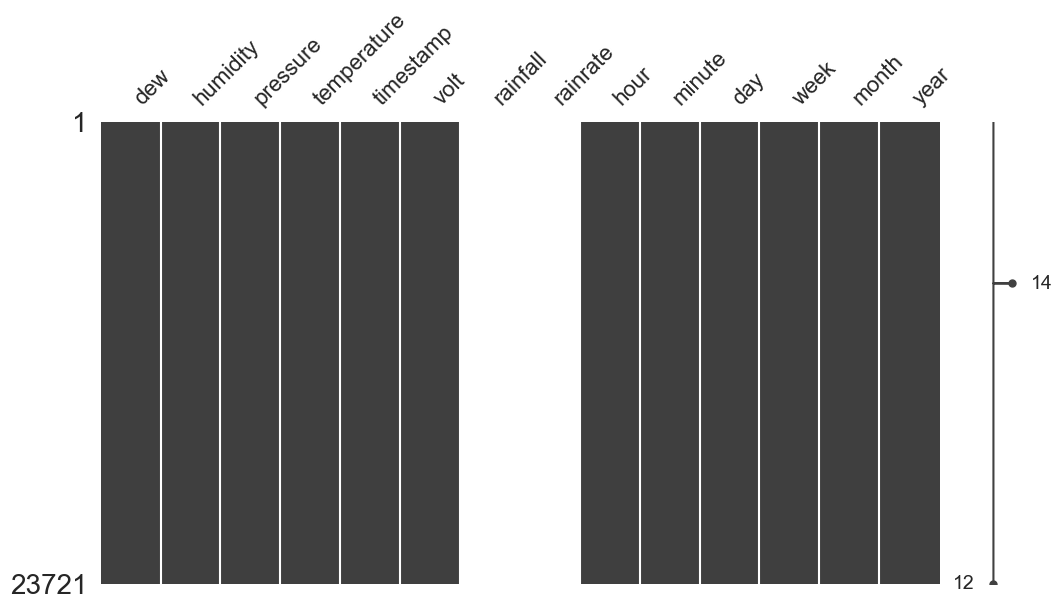


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 23720

Contoh baris dengan null:
                 dew  humidity  pressure  temperature  \
1761930000  24.54409     98.13   1011.90        24.86   
1761930060  24.51076     98.11   1011.88        24.83   
1761930120  24.54409     98.13   1011.88        24.86   
1761930180  24.55577     98.14   1011.87        24.87   
1761930241  24.54750     98.15   1011.84        24.86   
1761930301  24.54750     98.15   1011.85        24.86   
1761930361  24.56404     98.13   1011.80        24.88   
1761930421  24.54093     98.17   1011.79        24.85   
1761930481  24.53923     98.16   1011.78        24.85   
1761930541  24.54750     98.15   1011.82        24.86   

                           timestamp  volt  rainfall  rainrate  hour  minute  \
1761930000 2025-11-01 00:00:00+07:00  4.10       NaN       NaN     0       0   
1761930060 2025-11-01 00:01:00+07:00  4.10       NaN       NaN     0       1   
1761930120 2025-11-01 00:02:00+07:00  4.

In [171]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca1.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca1.isnull().sum() / len(cuaca1)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca1, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca1[cuaca1.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

=== Informasi Missing Values dalam cuaca3 ===

dew            0
humidity       0
pressure       0
rainfall       0
rainrate       0
temperature    0
timestamp      0
volt           0
hour           0
minute         0
day            0
week           0
month          0
year           0
dtype: int64


=== Persentase Missing Values ===

dew            0.0
humidity       0.0
pressure       0.0
rainfall       0.0
rainrate       0.0
temperature    0.0
timestamp      0.0
volt           0.0
hour           0.0
minute         0.0
day            0.0
week           0.0
month          0.0
year           0.0
dtype: float64


=== Visualisasi Missing Values ===


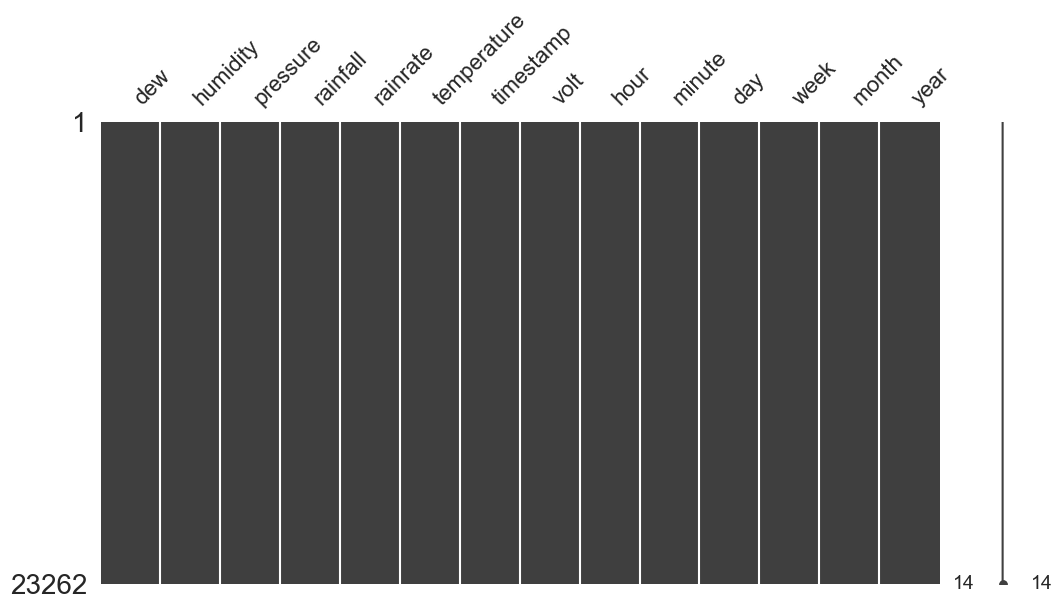


=== Baris dengan Nilai Null ===
Jumlah baris dengan null: 0

Contoh baris dengan null:
Empty DataFrame
Columns: [dew, humidity, pressure, rainfall, rainrate, temperature, timestamp, volt, hour, minute, day, week, month, year]
Index: []


In [172]:
# Mengecek nilai null dalam dataframe cuaca3
print("=== Informasi Missing Values dalam cuaca3 ===\n")
print(cuaca3.isnull().sum())
print("\n" + "="*50 + "\n")

# Menampilkan persentase missing values
print("=== Persentase Missing Values ===\n")
missing_percentage = (cuaca3.isnull().sum() / len(cuaca3)) * 100
print(missing_percentage)
print("\n" + "="*50 + "\n")

# Visualisasi missing values menggunakan missingno
print("=== Visualisasi Missing Values ===")
msno.matrix(cuaca3, figsize=(12, 6))
plt.show()

# Menampilkan baris-baris yang mengandung nilai null
print("\n=== Baris dengan Nilai Null ===")
null_rows = cuaca3[cuaca3.isnull().any(axis=1)]
print(f"Jumlah baris dengan null: {len(null_rows)}")
print("\nContoh baris dengan null:")
print(null_rows.head(10))

In [173]:
def plot_station_trends(data_dict, column_to_plot, freq='d'):
    """
    Membuat plot tren perbandingan untuk sebuah kolom dari beberapa stasiun cuaca.

    Args:
        data_dict (dict): Dictionary yang berisi {station_id: DataFrame}.
        column_to_plot (str): Nama kolom yang akan di-plot (misal: 'temperature').
        freq (str): Frekuensi untuk pengelompokan data.
                    'd' untuk harian (daily).
                    'h' untuk per jam (hourly).
    """
    # Menentukan label berdasarkan frekuensi
    freq_labels = {
        'd': {'label': 'Harian', 'xlabel': 'Tanggal'},
        'h': {'label': 'Per Jam', 'xlabel': 'Waktu (Jam)'},
        'min': {'label': 'Per Menit', 'xlabel': 'Waktu (Menit)'}
    }
    
    # Pilih label yang sesuai, default ke 'Harian' jika freq tidak dikenali
    selected_freq = freq_labels.get(freq, freq_labels['d'])
    
    # Membuat figure dan axes untuk plot
    plt.figure(figsize=(15, 7))

    # Loop melalui setiap stasiun dalam dictionary
    for station_id, df in data_dict.items():
        if column_to_plot not in df.columns:
            print(f"Peringatan: Kolom '{column_to_plot}' tidak ada di stasiun {station_id}. Dilewati.")
            continue

        temp_df = df.copy()
        
        # Mengelompokkan data berdasarkan frekuensi (harian atau per jam)
        time_group_col = f'time_group_{freq}'
        temp_df[time_group_col] = temp_df['timestamp'].dt.floor(freq)
        trend_data = temp_df.groupby(time_group_col)[column_to_plot].mean().reset_index()

        # Plot data untuk stasiun saat ini
        plt.plot(trend_data[time_group_col], trend_data[column_to_plot], label=station_id, alpha=0.8)

    # Menambahkan detail pada plot
    plt.xlabel(selected_freq['xlabel'])
    plt.ylabel(f"Rata-rata {column_to_plot.capitalize()}")
    plt.title(f"Perbandingan Rata-rata {selected_freq['label']} {column_to_plot.capitalize()} antar Stasiun")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # Menampilkan plot
    plt.show()

Menampilkan plot perbandingan per menit...


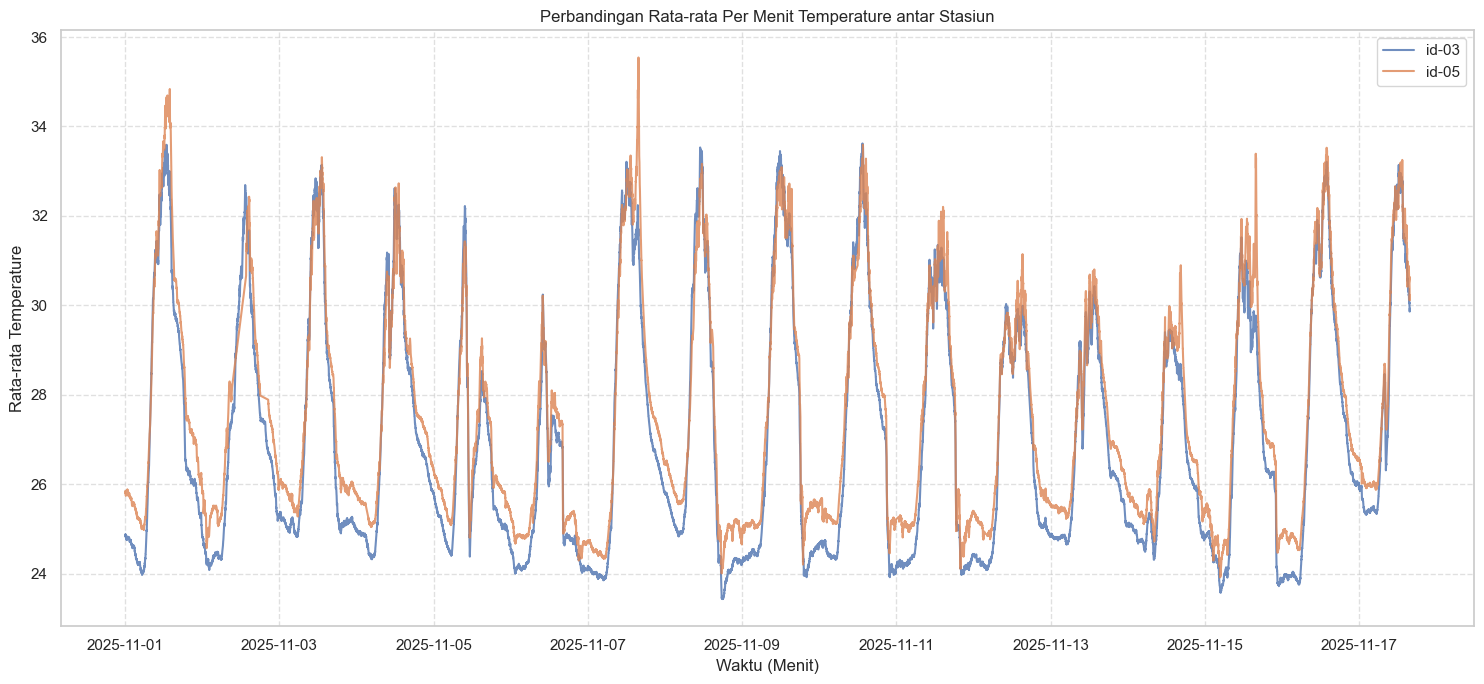

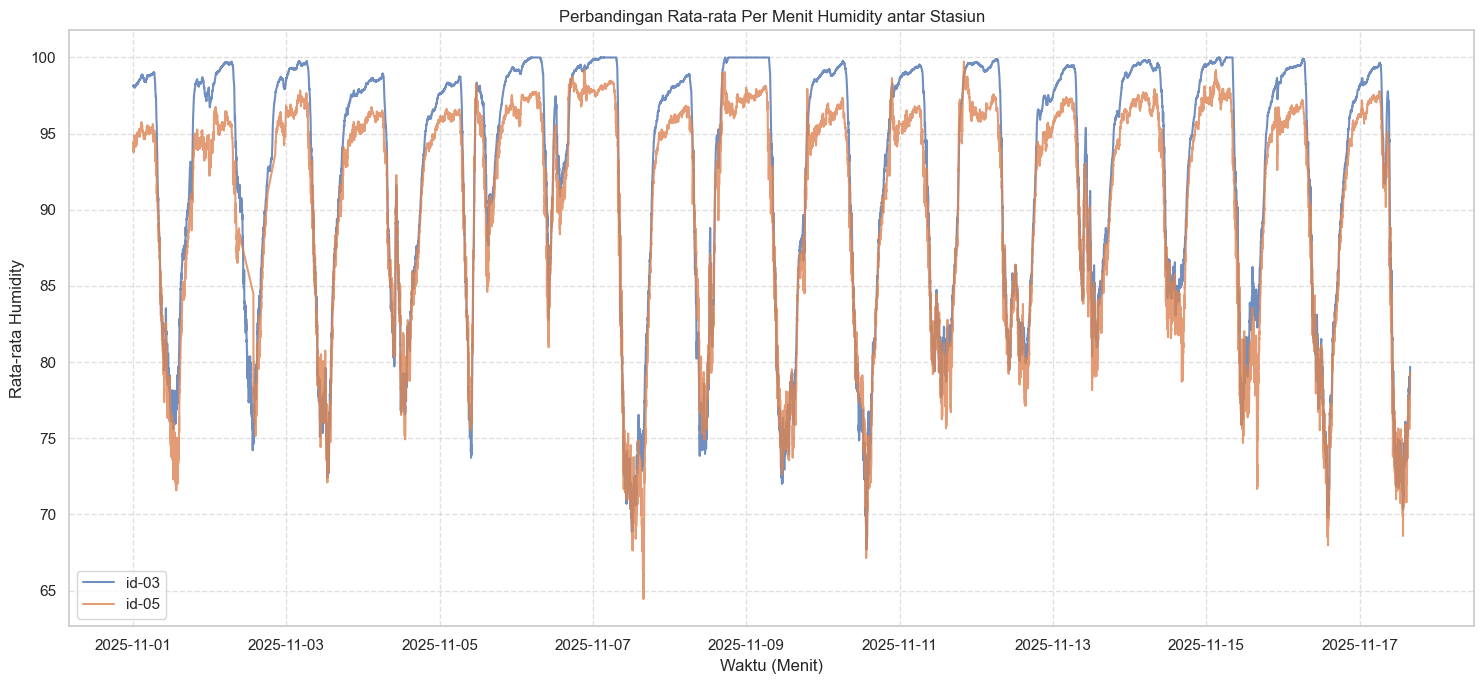

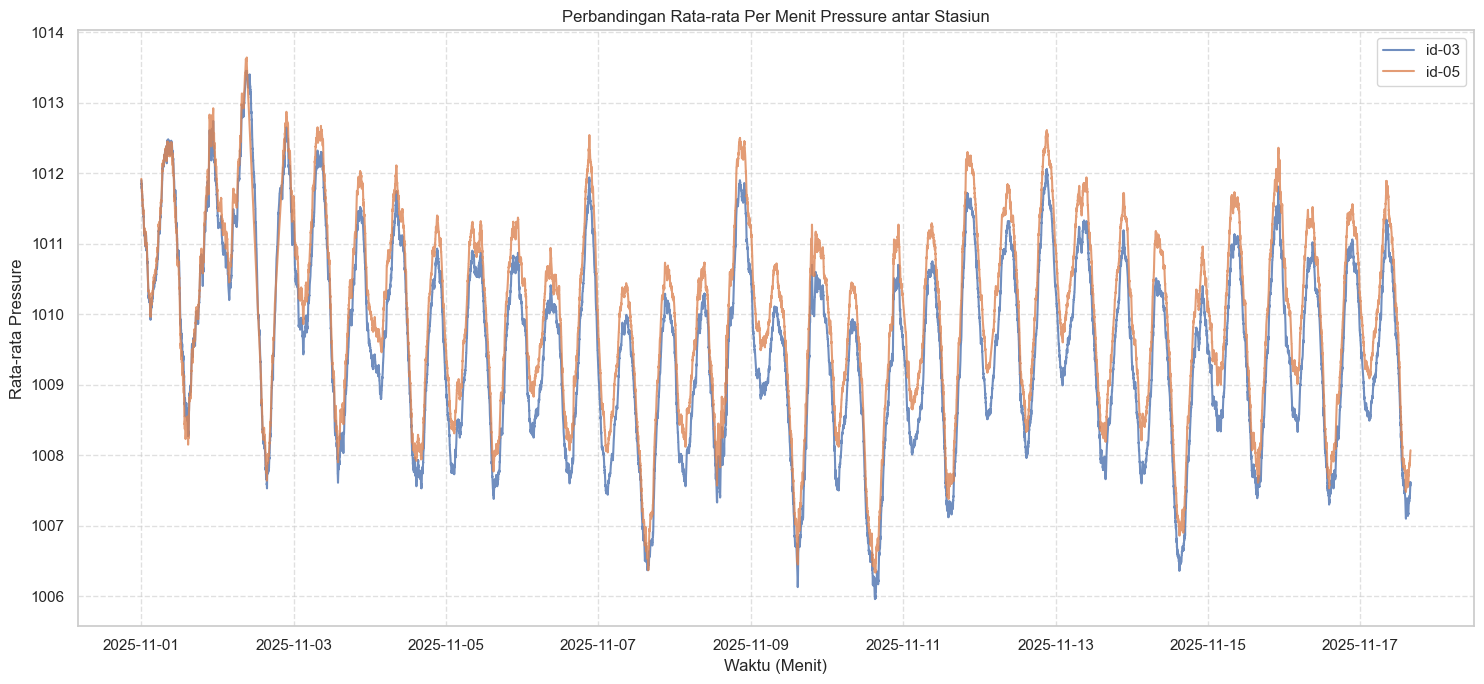

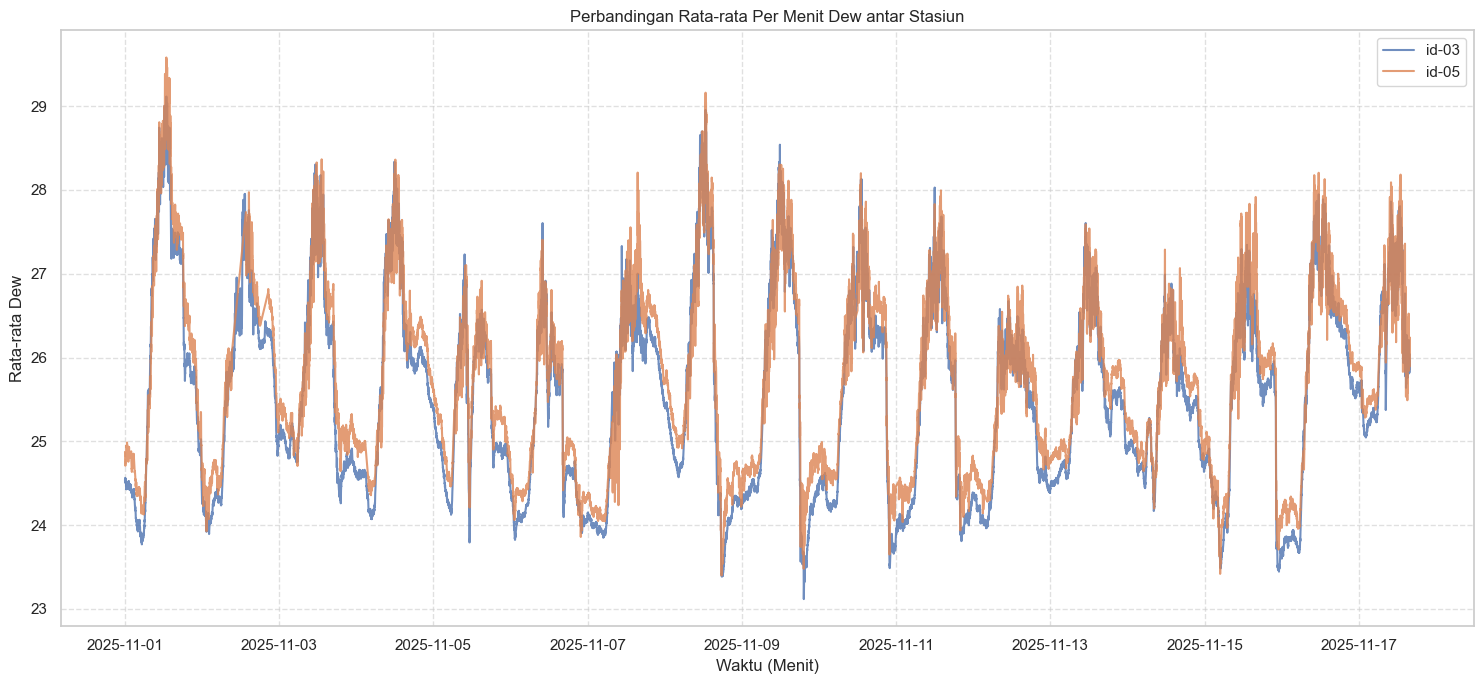

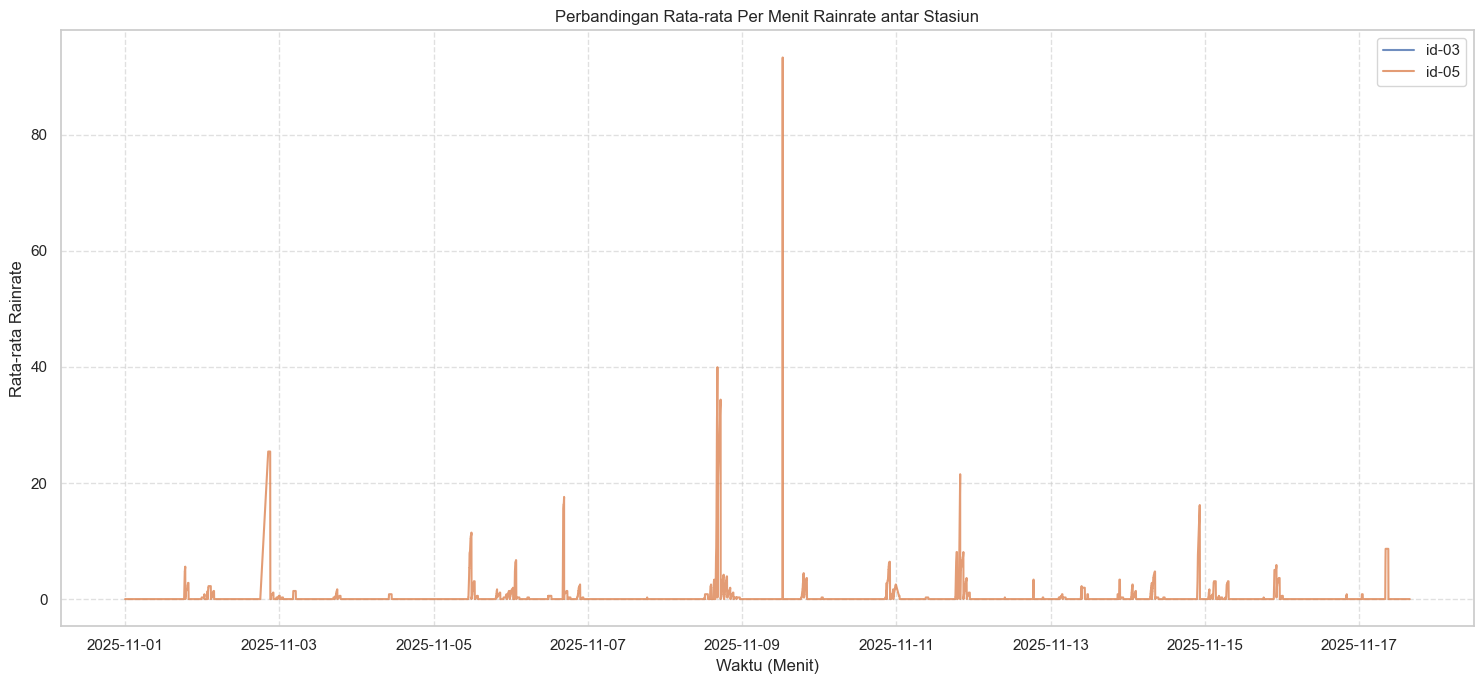

Menampilkan plot perbandingan per jam...


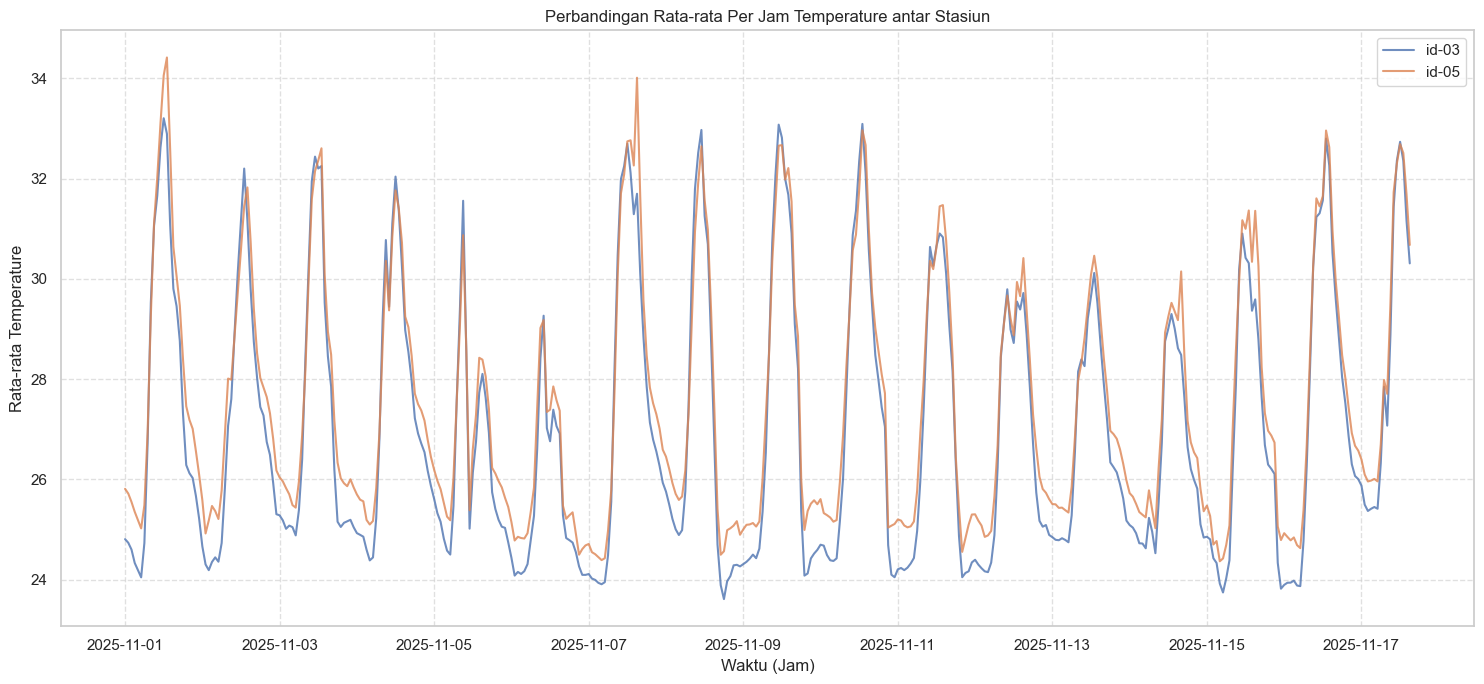

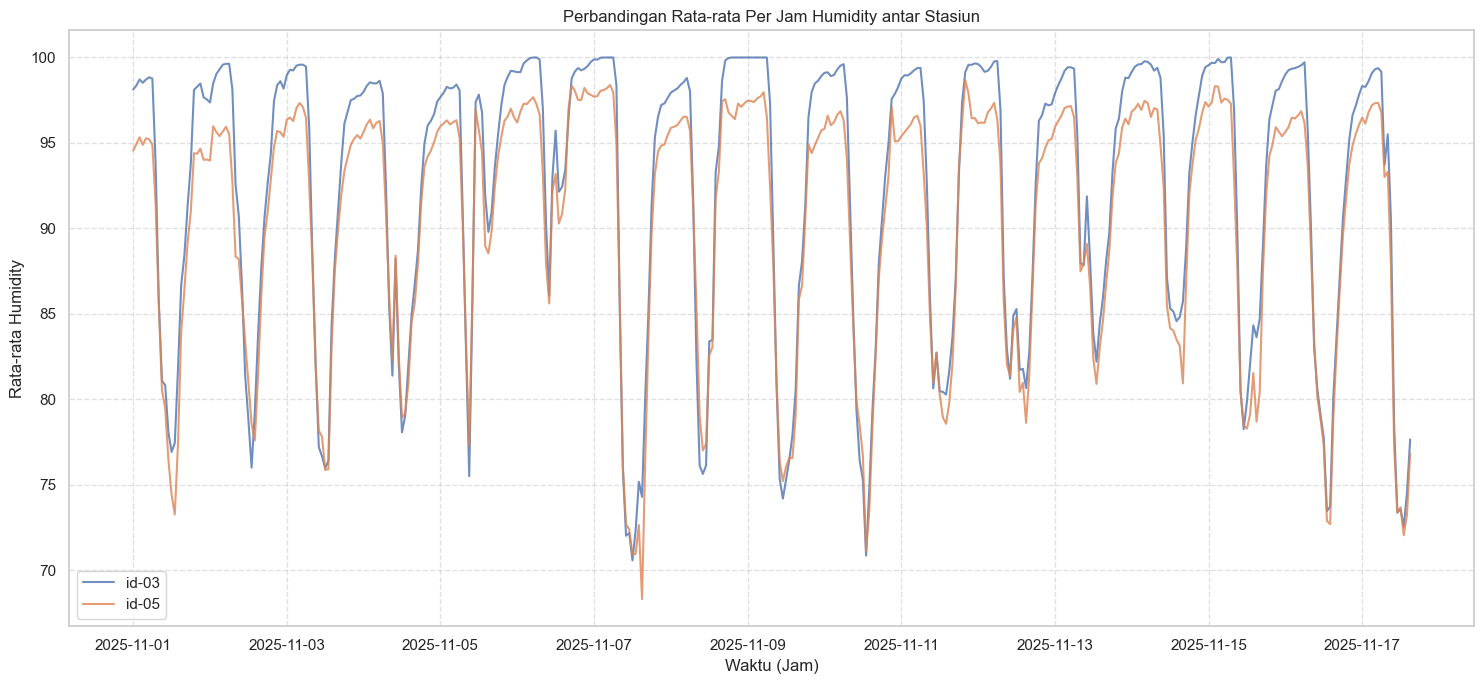

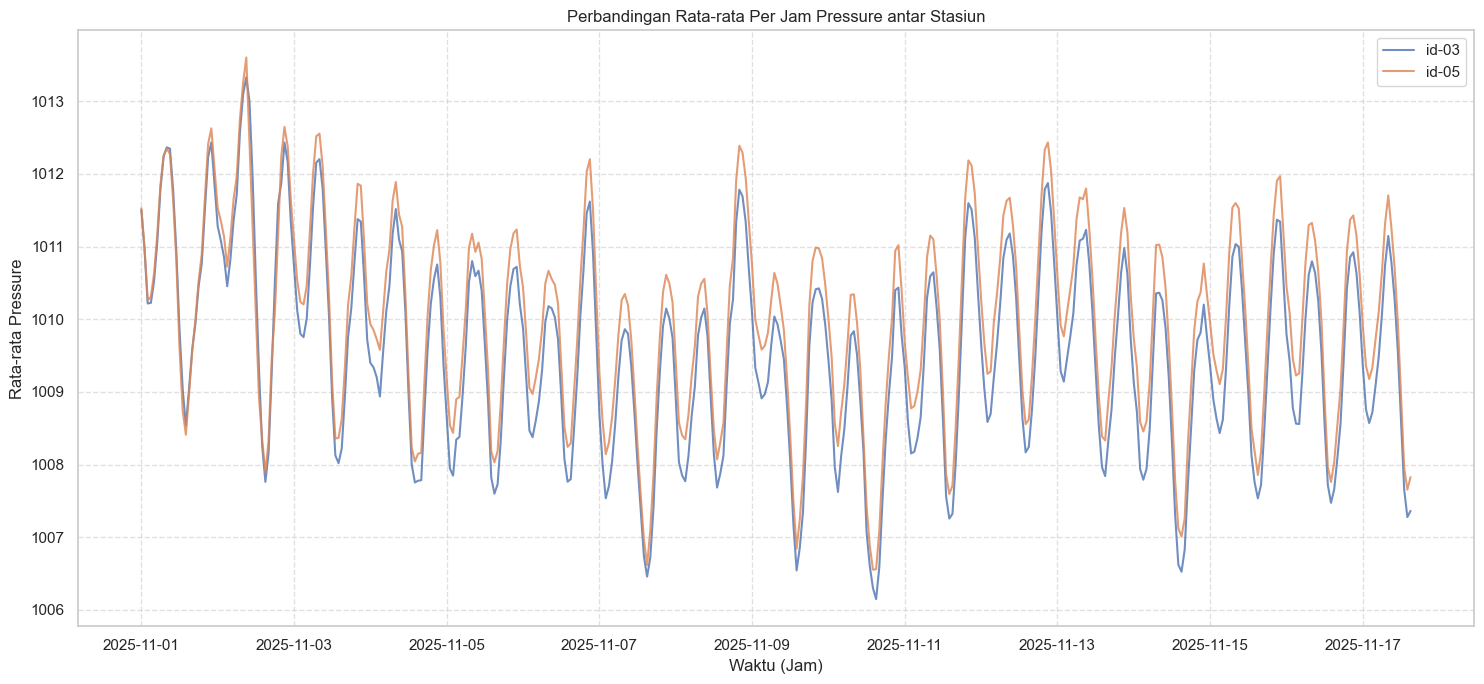

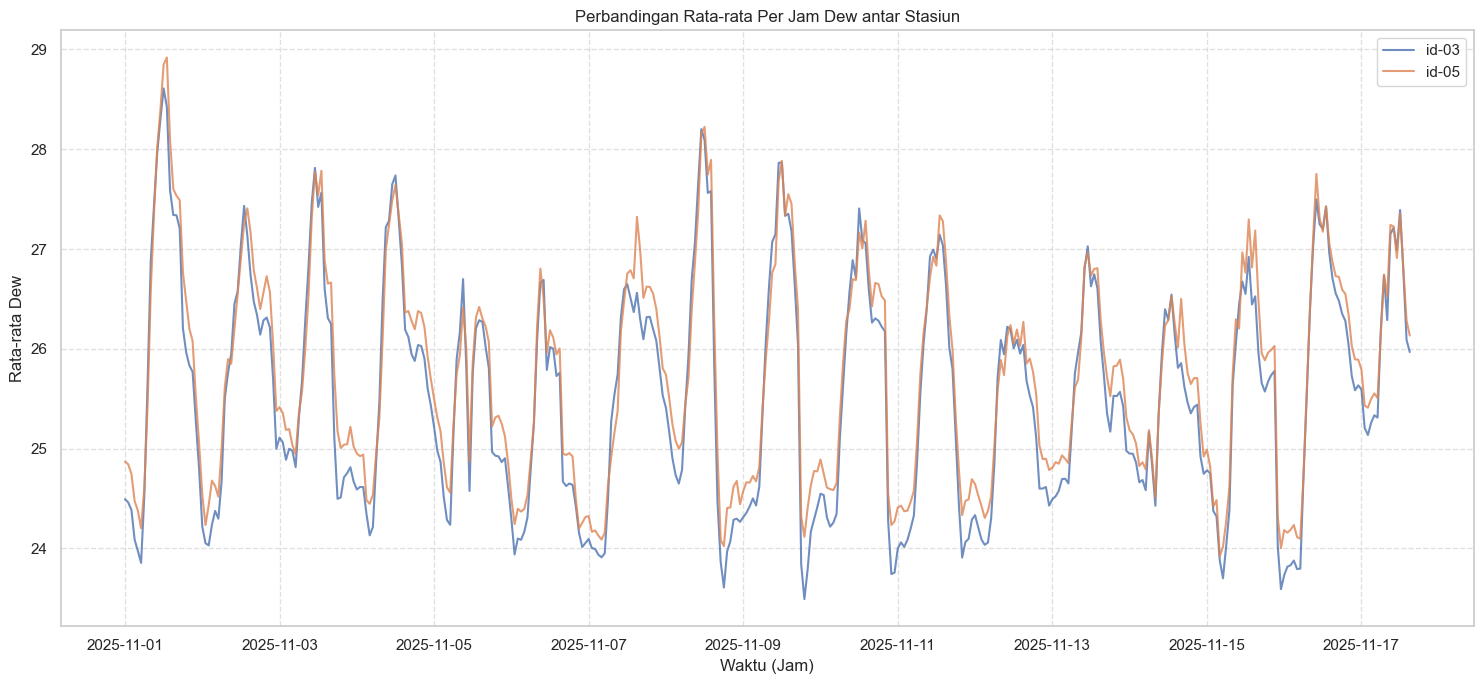

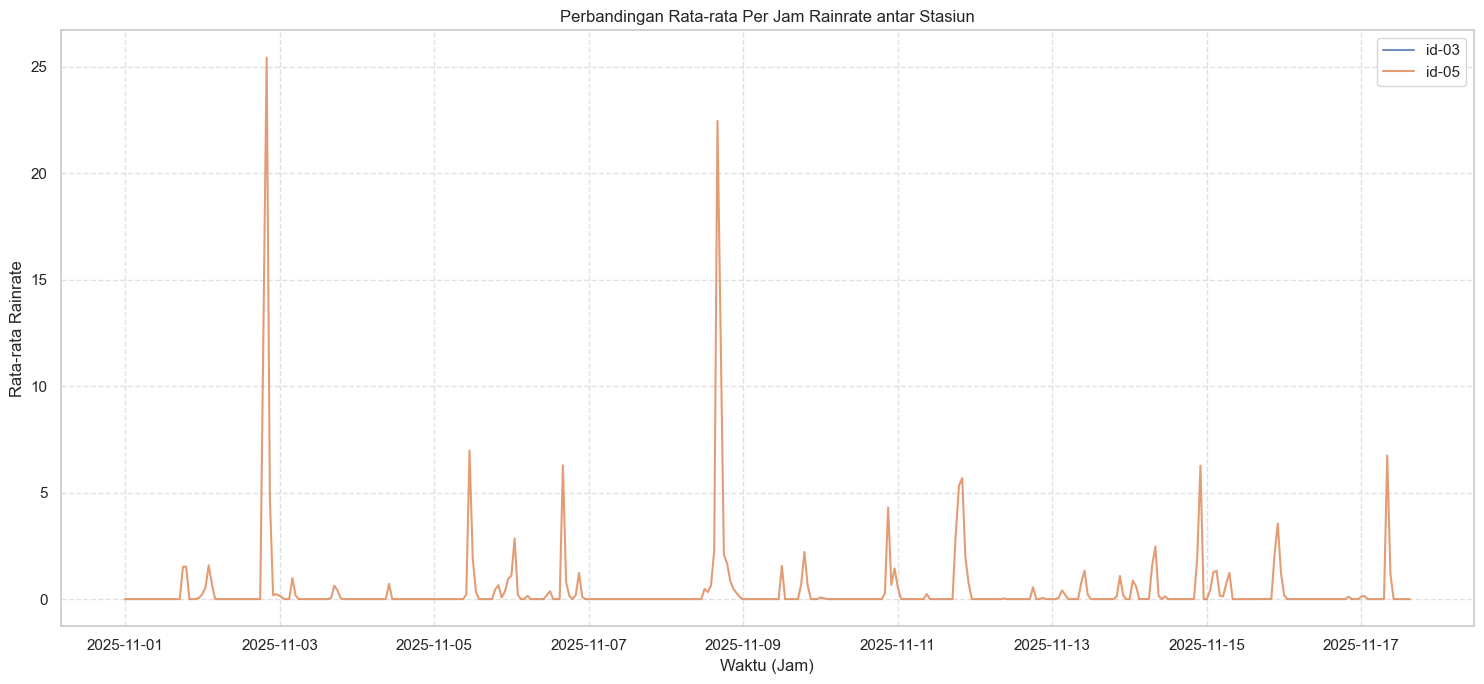


Menampilkan plot perbandingan per hari...


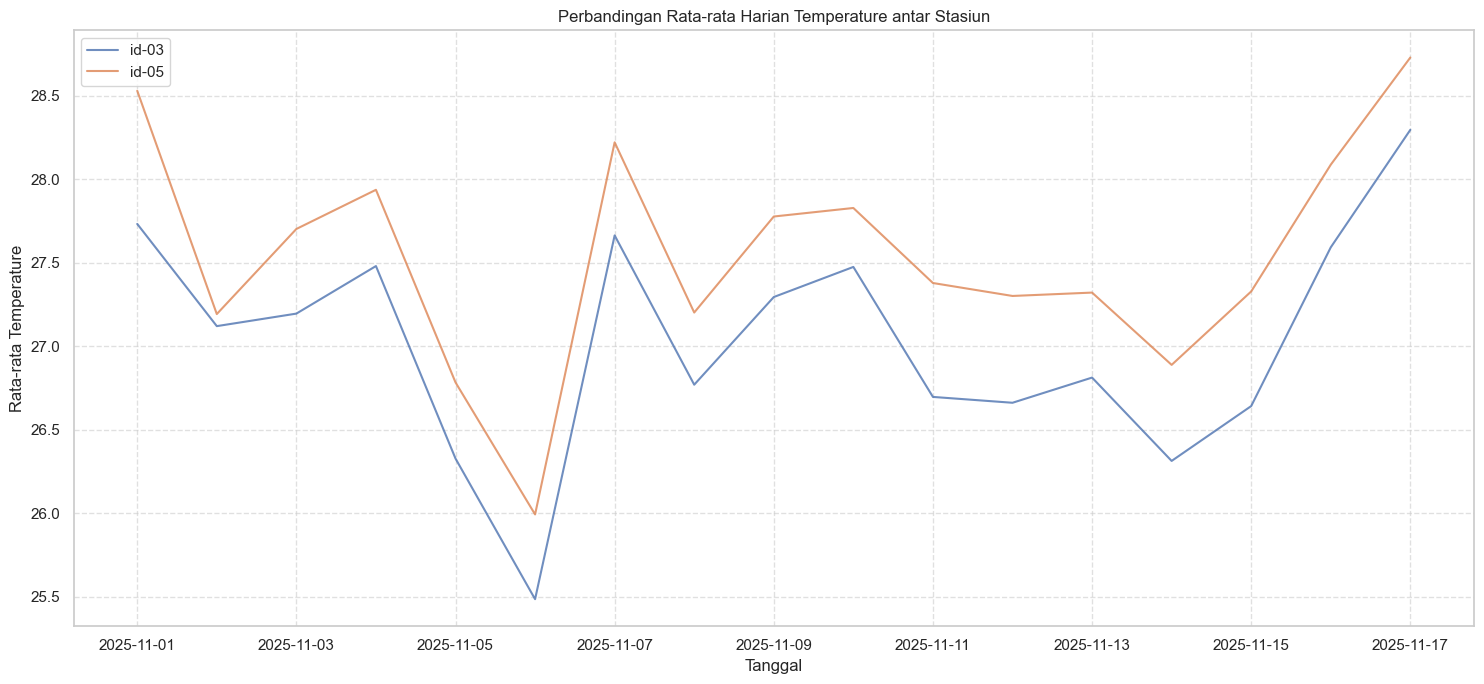

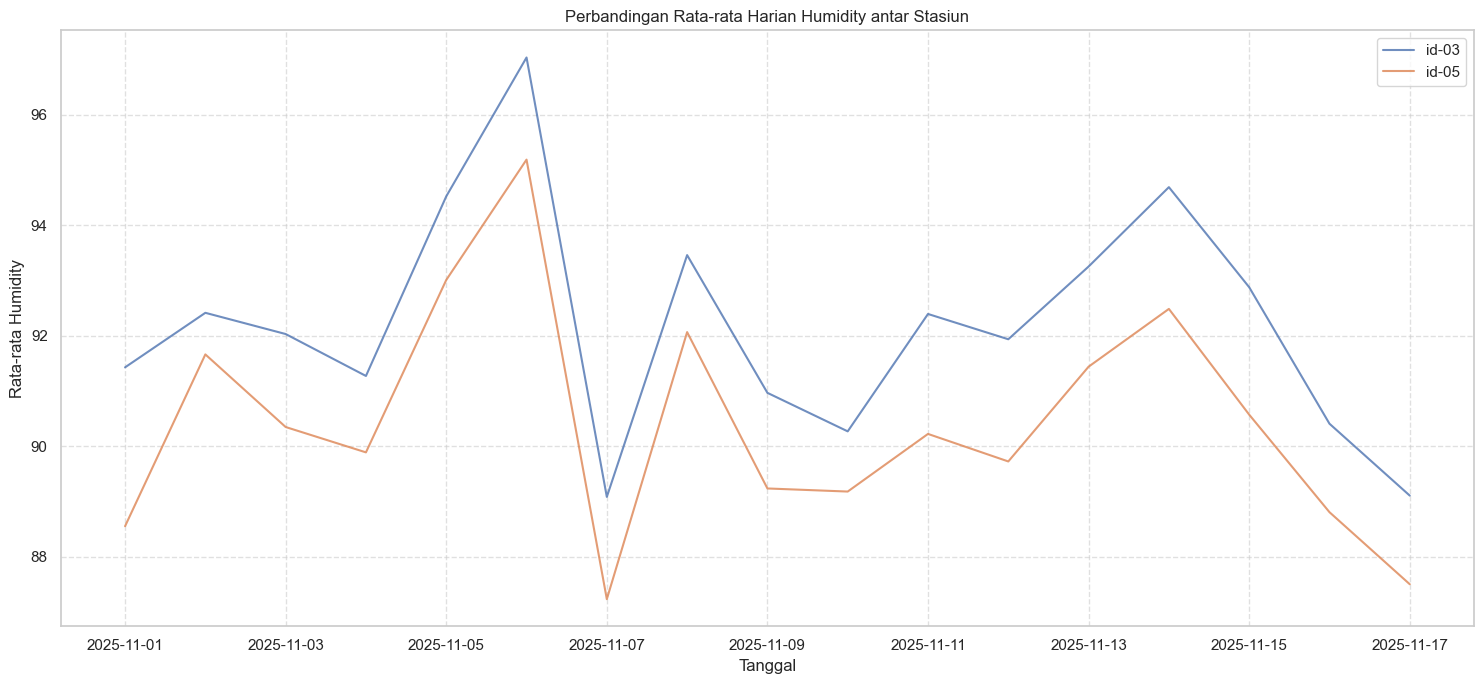

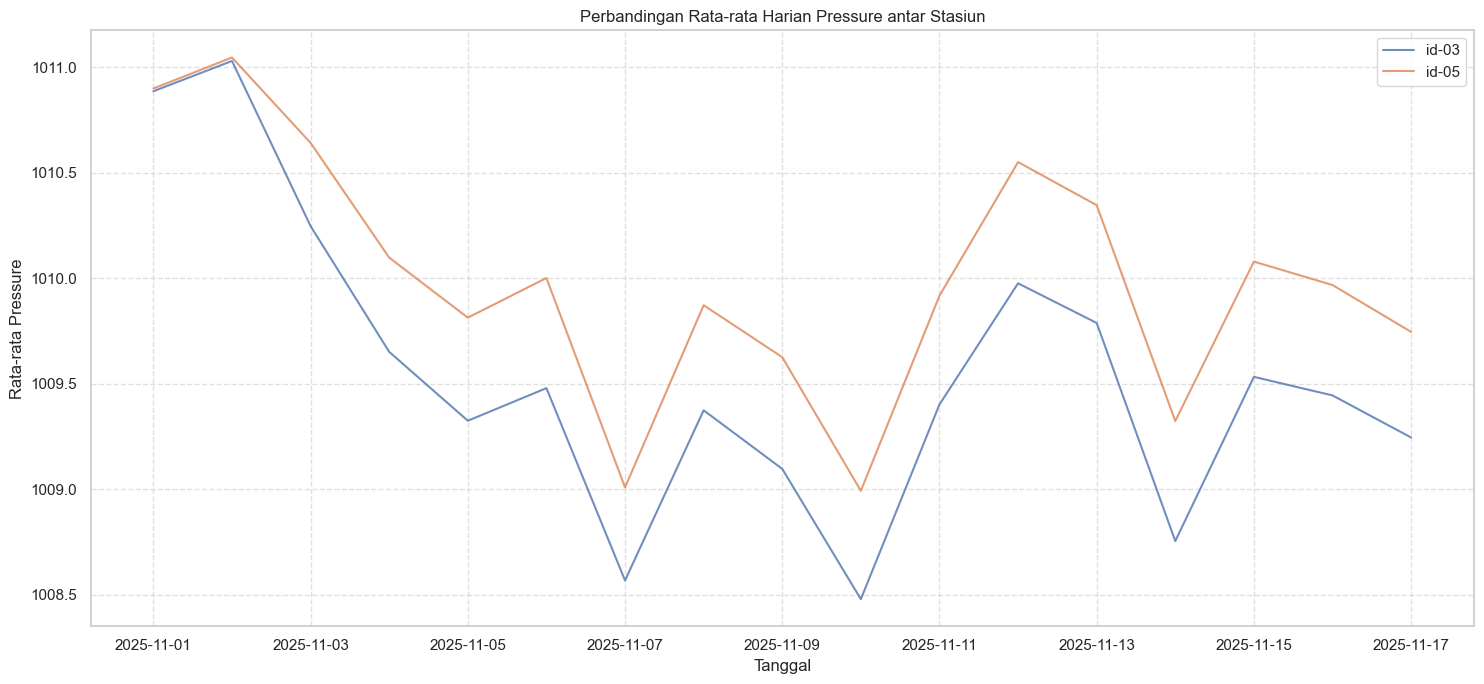

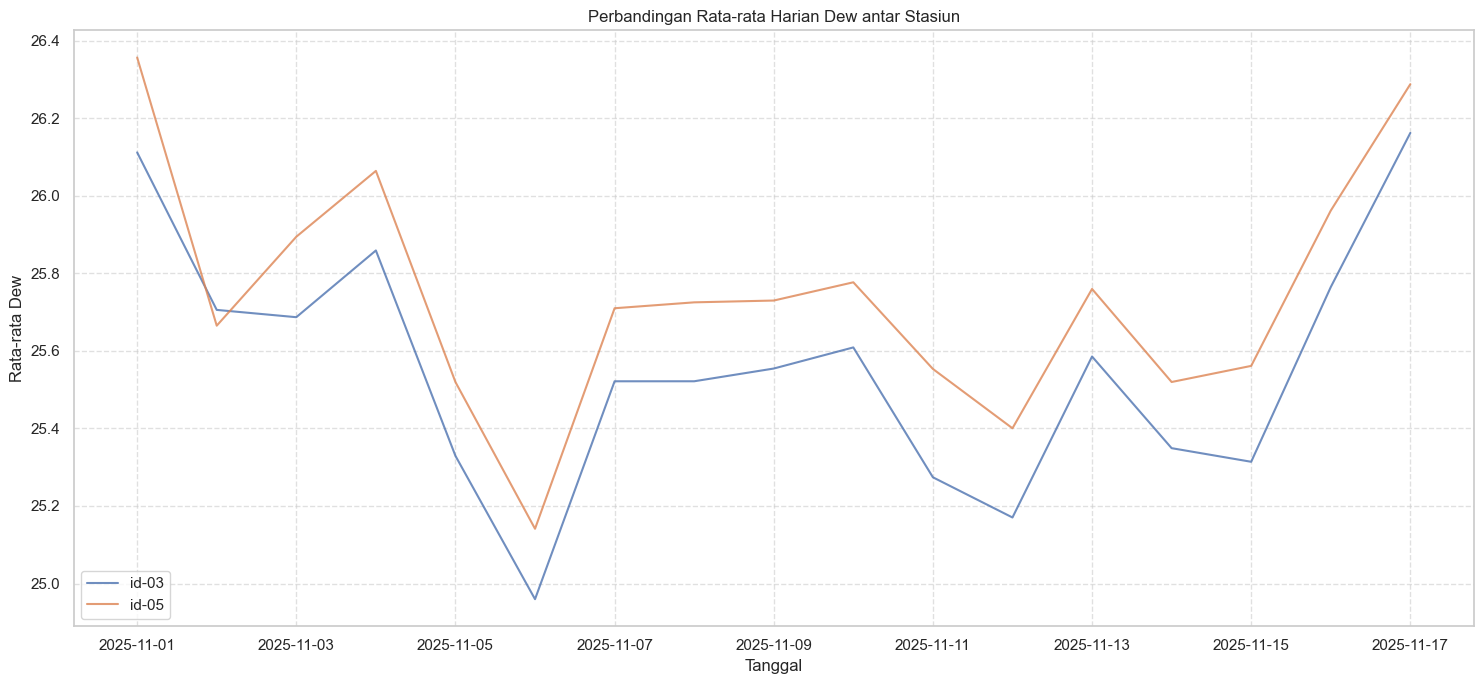

In [174]:
# Asumsi Anda sudah memiliki dictionary 'weather_dataframes'
print("Menampilkan plot perbandingan per menit...")
plot_station_trends(weather_dataframes, 'temperature', freq='min')
plot_station_trends(weather_dataframes, 'humidity', freq='min')
plot_station_trends(weather_dataframes, 'pressure', freq='min')
plot_station_trends(weather_dataframes, 'dew', freq='min')
plot_station_trends(weather_dataframes, 'rainrate', freq='min')
# --- 1. Membuat Plot Rata-rata PER JAM ---
# Cukup atur freq='h'
print("Menampilkan plot perbandingan per jam...")
plot_station_trends(weather_dataframes, 'temperature', freq='h')
plot_station_trends(weather_dataframes, 'humidity', freq='h')
plot_station_trends(weather_dataframes, 'pressure', freq='h')
plot_station_trends(weather_dataframes, 'dew', freq='h')
plot_station_trends(weather_dataframes, 'rainrate', freq='h')


# --- 2. Membuat Plot Rata-rata PER HARI ---
# Gunakan nilai default freq='d' atau tulis secara eksplisit
print("\nMenampilkan plot perbandingan per hari...")
plot_station_trends(weather_dataframes, 'temperature', freq='d')
plot_station_trends(weather_dataframes, 'humidity', freq='d')
plot_station_trends(weather_dataframes, 'pressure', freq='d')
plot_station_trends(weather_dataframes, 'dew', freq='d')

--- Curah Hujan Harian (Jumlah dari Maksimum per Jam) ---
timestamp
2025-10-31 00:00:00+00:00      0.0000
2025-11-01 00:00:00+00:00     15.3670
2025-11-02 00:00:00+00:00     56.1594
2025-11-03 00:00:00+00:00      4.1910
2025-11-04 00:00:00+00:00      0.8382
2025-11-05 00:00:00+00:00     32.1310
2025-11-06 00:00:00+00:00     24.3078
2025-11-07 00:00:00+00:00      0.2794
2025-11-08 00:00:00+00:00    100.0252
2025-11-09 00:00:00+00:00    104.7750
2025-11-10 00:00:00+00:00     18.1610
2025-11-11 00:00:00+00:00     42.7482
2025-11-12 00:00:00+00:00      5.3086
2025-11-13 00:00:00+00:00     13.6906
2025-11-14 00:00:00+00:00     46.1010
2025-11-15 00:00:00+00:00     18.4404
2025-11-16 00:00:00+00:00      2.5146
2025-11-17 00:00:00+00:00     17.3228
Freq: D, Name: rainrate, dtype: float64


--- Visualisasi Curah Hujan Harian ---

Plot berhasil disimpan di: plots\Curah_Hujan_Harian_id-05_2025-11.png


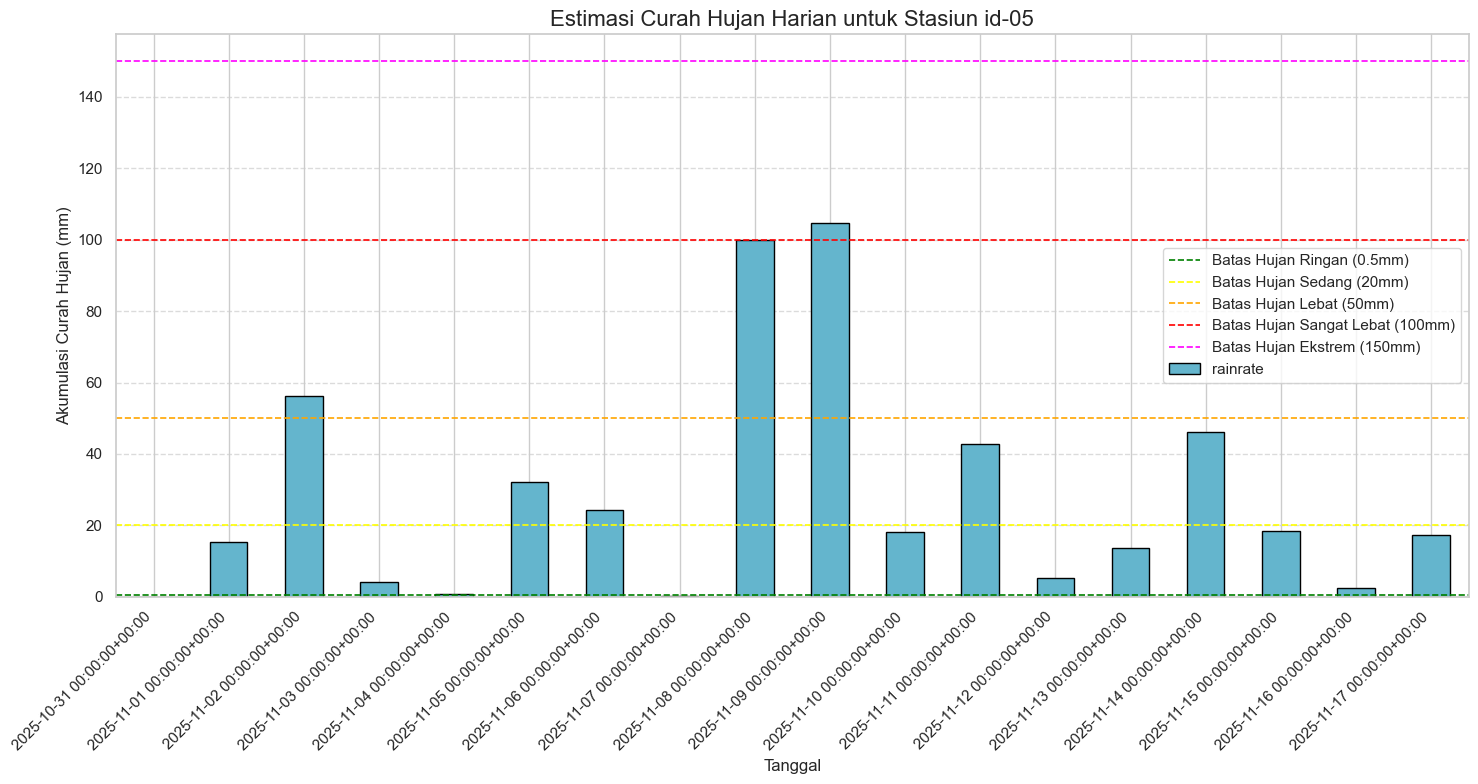

In [175]:
# Perhitungan curah hujan harian untuk stasiun 'id-05' (cuaca3)
# Sesuai permintaan, logika berikut akan:
# 1. Mencari nilai 'rainfall' maksimum untuk setiap jam.
# 2. Menjumlahkan nilai-nilai maksimum per jam tersebut untuk mendapatkan total harian.

# Salin dataframe untuk menghindari perubahan pada data asli
df_hujan = cuaca3.copy()

# Atur 'timestamp' sebagai indeks untuk mempermudah operasi time series
df_hujan.set_index('timestamp', inplace=True)

# Langkah 1: Resample data untuk mendapatkan nilai 'rainfall' maksimum per jam.
# 'H' adalah kode frekuensi untuk per jam (Hourly).
max_per_jam = df_hujan['rainrate'].resample('h').max()

# Langkah 2: Resample hasil dari langkah 1 untuk menjumlahkan semua nilai maksimum per hari.
# 'D' adalah kode frekuensi untuk harian (Daily).
# Pergantian hari diatur pada jam 7 pagi WIB (00:00 UTC) sesuai permintaan.
# Caranya dengan mengonversi zona waktu ke UTC sebelum melakukan resampling harian.
curah_hujan_harian = max_per_jam.tz_convert('UTC').resample('d').sum()

# Mengisi nilai NaN (jika ada hari tanpa data) dengan 0
curah_hujan_harian.fillna(0, inplace=True)


# Tampilkan hasilnya dalam bentuk tabel
print("--- Curah Hujan Harian (Jumlah dari Maksimum per Jam) ---")
print(curah_hujan_harian)
print("\n" + "="*50 + "\n")

# --- Visualisasi Hasil ---
print("--- Visualisasi Curah Hujan Harian ---")
plt.figure(figsize=(15, 8))
curah_hujan_harian.plot(kind='bar', color='c', edgecolor='black')

# Menambahkan garis batas kategori hujan sesuai standar BMKG
# Kategori Umum: Ringan (<20), Sedang (20-50), Lebat (50-100), Sangat Lebat (100-150), Ekstrem (>150)
plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.2, label='Batas Hujan Ringan (0.5mm)')
plt.axhline(y=20, color='yellow', linestyle='--', linewidth=1.2, label='Batas Hujan Sedang (20mm)')
plt.axhline(y=50, color='orange', linestyle='--', linewidth=1.2, label='Batas Hujan Lebat (50mm)')
plt.axhline(y=100, color='red', linestyle='--', linewidth=1.2, label='Batas Hujan Sangat Lebat (100mm)')
plt.axhline(y=150, color='magenta', linestyle='--', linewidth=1.2, label='Batas Hujan Ekstrem (150mm)')


plt.title('Estimasi Curah Hujan Harian untuk Stasiun id-05', fontsize=16)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Akumulasi Curah Hujan (mm)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend() # Menampilkan label dari garis batas
plt.tight_layout()

# --- Menyimpan Plot ---
# Membuat folder 'plots' jika belum ada
output_folder = 'plots'
if not os.path.exists(output_folder):
	os.makedirs(output_folder)

# Mendapatkan rentang tanggal untuk nama file
start_dt = datetime.strptime(start_readable_date, "%d-%m-%Y %H:%M:%S")
end_dt = datetime.strptime(end_readable_date, "%d-%m-%Y %H:%M:%S")

# Format nama file berdasarkan rentang bulan dan tahun
if start_dt.year == end_dt.year and start_dt.month == end_dt.month:
	file_period = start_dt.strftime('%Y-%m') # Format YYYY-MM
else:
	file_period = f"{start_dt.strftime('%Y-%m')}_to_{end_dt.strftime('%Y-%m')}"

filename = f"Curah_Hujan_Harian_id-05_{file_period}.png"
filepath = os.path.join(output_folder, filename)

# Simpan gambar
plt.savefig(filepath, dpi=300)
print(f"\nPlot berhasil disimpan di: {filepath}")

# Tampilkan plot
plt.show()